In [1]:
import numpy as np
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.read_csv('/home/daniel/Downloads/bq-results-20221024-192803-1666639724268.csv')

In [4]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,molregno_1,molregno_2,fragment_md5_1,fragment_md5_2,radius,tid_1,tid_2,tid_3,tid_4
0,40ef89666a8e476e324557c726c40557,1907404,IC50,NaN,2347913,2374257,8b6d885a266c725fddf935d31e1aaa12,7ce082bff00ce2cf796a9ab8cc1779ad,4,12697,117134.0,NaN,NaN
1,40ef89666a8e476e324557c726c40557,1907404,IC50,NaN,2347913,2374257,4bab53fbc1d4bc2dc9826c62874faf90,1549251a9c0e182d0b73e88bbfa6ce35,1,12697,109653.0,104681.0,NaN
2,40ef89666a8e476e324557c726c40557,1907404,IC50,NaN,2347913,2374257,4bab53fbc1d4bc2dc9826c62874faf90,1549251a9c0e182d0b73e88bbfa6ce35,1,12697,117757.0,104681.0,NaN


In [5]:
len(df.index)

6395429

In [6]:
pd.DataFrame(pd.concat([df.molregno_1, df.molregno_2]).unique()).reset_index()

,index,0
0,0,2347913
1,1,2371535
2,2,2461748
3,3,2458777
4,4,21184
...,...,...
33301,33301,264114
33302,33302,591660
33303,33303,396841
33304,33304,1960937


In [7]:
s = pd.concat([df.molregno_1, df.molregno_2]).unique()
np.random.shuffle(s)
s = pd.Series(range(len(s)), index=s).rename('molregno_1_idx')
df = df.join(s, on='molregno_1')
s.rename('molregno_2_idx', inplace=True)
df = df.join(s, on='molregno_2')

In [8]:
df_melt = df.melt(id_vars='assay_id', value_vars=['tid_1', 'tid_2', 'tid_3', 'tid_4'])
df_melt.dropna(inplace=True)
df_melt.drop_duplicates(['assay_id', 'value'], inplace=True, keep='last')

In [9]:
df_melt['var_idx'] = df_melt.variable.str.extract('(\d+)').astype(int)
df_melt = df_melt.join(
    df_melt.groupby('assay_id')['var_idx'].apply(
        lambda x: pd.Series((1+x.max())-x, index=x.index)).rename('new'))

In [10]:
df_melt[df_melt.assay_id==df_melt.assay_id.sample(1).squeeze()]

,assay_id,variable,value,var_idx,new
6165758,1629223,tid_1,108.0,1,4
12561069,1629223,tid_2,104992.0,2,3
12561187,1629223,tid_2,104817.0,2,3
18956616,1629223,tid_3,104784.0,3,2
25352045,1629223,tid_4,104841.0,4,1


In [11]:
df.drop(['tid_1', 'tid_2', 'tid_3', 'tid_4'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [12]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,molregno_1,molregno_2,fragment_md5_1,fragment_md5_2,radius,molregno_1_idx,molregno_2_idx
0,40ef89666a8e476e324557c726c40557,1907404,IC50,NaN,2347913,2374257,8b6d885a266c725fddf935d31e1aaa12,7ce082bff00ce2cf796a9ab8cc1779ad,4,30113,5539
1,40ef89666a8e476e324557c726c40557,1907404,IC50,NaN,2347913,2374257,4bab53fbc1d4bc2dc9826c62874faf90,1549251a9c0e182d0b73e88bbfa6ce35,1,30113,5539
3,2b0039cd8e8b8f8abb5179d9a25e1c84,1907406,IC50,NaN,2371535,2369372,0ef4d3a6676dfff2cde260b0a4d8a45e,a16d252d536b052bd9d8dc64a80dcd1d,2,17025,2496


In [13]:
len(df.index)

3595806

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

def eloCV(df):
    
    # create a table where winner / loser is defined
    df_train = df[df.standard_change.isin(['increase', 'decrease'])].copy(deep=True)
    if df_train.empty: return None
    df_train['label'] = df_train.standard_change=='increase'

    # use index as timeseries
    df_train['timestamp'] = df_train[['molregno_1_idx', 'molregno_2_idx']].max(axis=1)
    df_train.sort_values('timestamp', inplace=True)
    df_train.reset_index(inplace=True)
        
    model = EloEstimator(
        key1_field="fragment_md5_1",
        key2_field="fragment_md5_2",
        timestamp_field="timestamp",
        initial_time=0
    )
    
    # fit model
    clf = GridSearchCV(
        model,
        param_grid={
            'default_k': [
                20, 40, 60, 100, 160
            ]
        },
        scoring='neg_median_absolute_error',
        cv=[(df_train.index, df_train.index)]
        ).fit(df_train, df_train.label)

    # return proba
    #df_train['proba'] = model.transform(df_train, output_type='prob', strict_past_data=True)
    #return df_train[['wizepair2_uuid', 'proba', 'label']] 
    return pd.DataFrame(clf.cv_results_)


In [15]:
df_elocv = df.groupby(['assay_id', 'radius']).parallel_apply(eloCV)

In [16]:
df_elocv.groupby(['param_default_k'])['mean_test_score'].mean()

param_default_k
20    -0.298812
40    -0.298734
60    -0.298798
100   -0.298727
160   -0.298939
Name: mean_test_score, dtype: float64

In [17]:
def elo(df):
    
    # create a table where winner / loser is defined
    df_train = df[df.standard_change.isin(['increase', 'decrease'])].copy(deep=True)
    if df_train.empty: return None
    df_train['label'] = df_train.standard_change=='increase'

    # use index as timeseries
    df_train['timestamp'] = df_train[['molregno_1_idx', 'molregno_2_idx']].max(axis=1)
    df_train.sort_values('timestamp', inplace=True)
    df_train.reset_index(inplace=True)
    
    # fit model
    model = EloEstimator(
        key1_field="fragment_md5_1",
        key2_field="fragment_md5_2",
        timestamp_field="timestamp",
        initial_time=0,
        default_k=60
    ).fit(df_train, df_train.label)
    
    # return proba
    df_train['proba'] = model.transform(df_train, output_type='prob', strict_past_data=True)
    try: return df_train[['wizepair2_uuid', 'assay_id', 'proba', 'label']]
    except KeyError: return df_train[['wizepair2_uuid', 'proba', 'label']]
    

In [18]:
df_elo = df.groupby(['assay_id', 'radius']).parallel_apply(elo)

In [19]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    0.001622
0.1    0.273669
0.5    0.500000
0.9    0.727061
1.0    0.998378
Name: proba, dtype: float64

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.7576284270356538

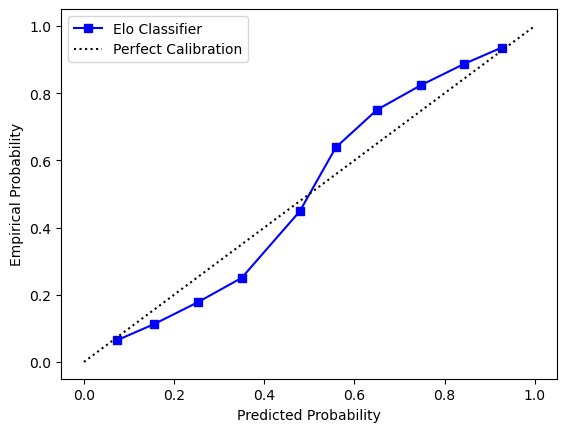

In [21]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [22]:
df_merge = df.merge(df_melt, on='assay_id')

In [23]:
len(df_merge.index)

6858452

In [24]:
df_merge_elocv = df_merge.groupby(['standard_type', 'value', 'radius']).parallel_apply(eloCV)

In [25]:
df_merge_elocv.groupby('param_default_k')['mean_test_score'].mean()

param_default_k
20    -0.214971
40    -0.214830
60    -0.214830
100   -0.214901
160   -0.214690
Name: mean_test_score, dtype: float64

In [26]:
df_merge_elo = df_merge.groupby(['standard_type', 'value', 'radius']).parallel_apply(elo)

In [27]:
df_merge_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    1.202657e-11
0.1    2.205858e-01
0.5    5.000000e-01
0.9    7.818366e-01
1.0    1.000000e+00
Name: proba, dtype: float64

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_merge_elo.label, df_merge_elo.proba)

0.7399836189945551

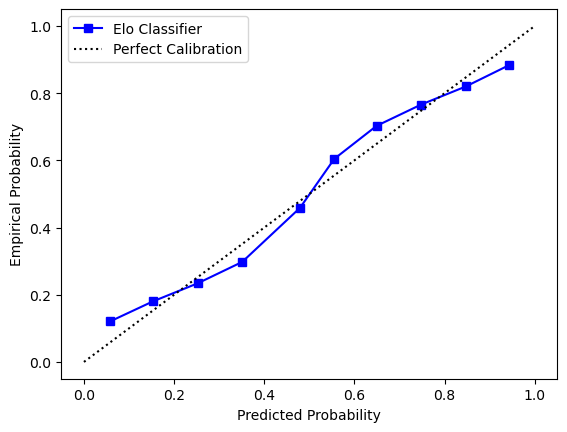

In [29]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_merge_elo.label,
  df_merge_elo.proba,
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [30]:
df_merge_elo.sort_values('proba', ascending=False)

wizepair2_uuid  \
standard_type value    radius                                           
Ki            104764.0 1      54396  94190a240d110ec0c33ef6f2c121a3b8   
                              55125  94190a240d110ec0c33ef6f2c121a3b8   
                              53447  94190a240d110ec0c33ef6f2c121a3b8   
                              53844  94190a240d110ec0c33ef6f2c121a3b8   
                              55462  94190a240d110ec0c33ef6f2c121a3b8   
...                                                               ...   
                              54482  e566c2f8b1aa5928b367a3dc39916270   
                              54498  e566c2f8b1aa5928b367a3dc39916270   
                              54550  e566c2f8b1aa5928b367a3dc39916270   
                              54575  e566c2f8b1aa5928b367a3dc39916270   
                              56491  e566c2f8b1aa5928b367a3dc39916270   

                                     assay_id         proba  label  
standard_type value    radius                                       
Ki            104764.0 1      54396    826238  1.000000e+00   True  
                              55125   1543851  1.000000e+00   True  
                              53447     47514  1.000000e+00   True  
                              53844    497635  1.000000e+00   True  
                              55462     47515  1.000000e+00   True  
...                                       ...           ...    ...  
                              54482    347176  1.202657e-11  False  
                              54498     45443  1.202657e-11   True  
                              54550    562985  1.202657e-11  False  
                              54575     45247  1.202657e-11   True  
                              56491     45078  1.202657e-11  False  

[5860565 rows x 4 columns]

In [38]:
df_merge[(df_merge.wizepair2_uuid=='94190a240d110ec0c33ef6f2c121a3b8') & (df_merge.value==104764.0)].groupby(
    ['standard_type', 'value', 'radius', 'standard_change', 'molregno_1', 'molregno_2']).size().sort_values()

standard_type  value     radius  standard_change  molregno_1  molregno_2
IC50           104764.0  1       decrease         1148        969            2
                         2       decrease         1148        969            2
                         3       decrease         1148        969            2
                         4       decrease         1148        969            2
Ki             104764.0  1       decrease         1148        969           13
                         2       decrease         1148        969           13
                         3       decrease         1148        969           13
                         4       decrease         1148        969           13
                         1       increase         1148        969           48
                         2       increase         1148        969           48
                         3       increase         1148        969           48
                         4       increase         1148    

In [34]:
df_merge[(df_merge.wizepair2_uuid=='94190a240d110ec0c33ef6f2c121a3b8') & (df_merge.value==104764.0) & (df_merge.radius==1)]

,wizepair2_uuid,assay_id,standard_type,standard_change,molregno_1,molregno_2,fragment_md5_1,fragment_md5_2,radius,molregno_1_idx,molregno_2_idx,variable,value,var_idx,new
435742,94190a240d110ec0c33ef6f2c121a3b8,325762,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
1598891,94190a240d110ec0c33ef6f2c121a3b8,305668,IC50,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
1749804,94190a240d110ec0c33ef6f2c121a3b8,325761,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
3104083,94190a240d110ec0c33ef6f2c121a3b8,423832,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_2,104764.0,2,1
3398817,94190a240d110ec0c33ef6f2c121a3b8,302350,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_2,104764.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475672,94190a240d110ec0c33ef6f2c121a3b8,303196,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
6478897,94190a240d110ec0c33ef6f2c121a3b8,517303,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
6500824,94190a240d110ec0c33ef6f2c121a3b8,45443,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
6531121,94190a240d110ec0c33ef6f2c121a3b8,45446,Ki,decrease,1148,969,67deba9cd7169ffa34e73e519e249d69,4fc9d18145af23420e3a43b3304480ba,1,26142,24348,tid_3,104764.0,3,1
